In [4]:
import numpy as np
import pandas as pd
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
import datetime
import yfinance as yf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

from pandas import DataFrame

In [5]:
NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
start = "2021-01-01"
end = datetime.datetime.today()
symbol = 'AAPL'
df = yf.download(symbol, start = start, end = end, interval = INTERVAL).reset_index()
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,133.520004,133.610001,126.760002,129.410004,128.264969,143301900
1,2021-01-05,128.889999,131.740005,128.429993,131.009995,129.850845,97664900
2,2021-01-06,127.720001,131.050003,126.379997,126.599998,125.479843,155088000
3,2021-01-07,128.360001,131.630005,127.860001,130.919998,129.761627,109578200
4,2021-01-08,132.429993,132.630005,130.229996,132.050003,130.881638,105158200


In [6]:
print(df.head())
print(df.shape)
print(df.columns)

        Date        Open        High         Low       Close   Adj Close  \
0 2021-01-04  133.520004  133.610001  126.760002  129.410004  128.264969   
1 2021-01-05  128.889999  131.740005  128.429993  131.009995  129.850845   
2 2021-01-06  127.720001  131.050003  126.379997  126.599998  125.479843   
3 2021-01-07  128.360001  131.630005  127.860001  130.919998  129.761627   
4 2021-01-08  132.429993  132.630005  130.229996  132.050003  130.881638   

      Volume  
0  143301900  
1   97664900  
2  155088000  
3  109578200  
4  105158200  
(347, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


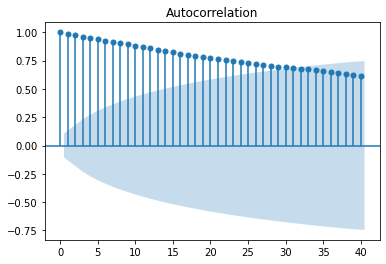

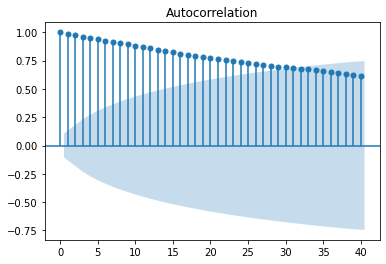

In [7]:
sm.graphics.tsa.plot_acf(df['Open'],lags=40)

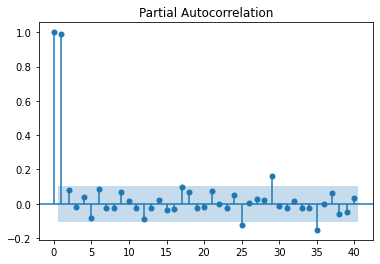

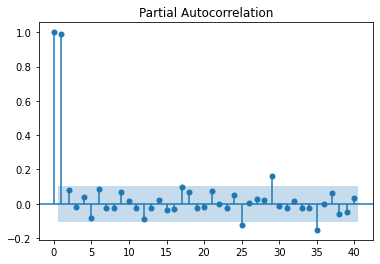

In [8]:
sm.graphics.tsa.plot_pacf(df['Open'],lags=40)

Text(0.5, 1.0, 'AAPL Autocorrelation plot')

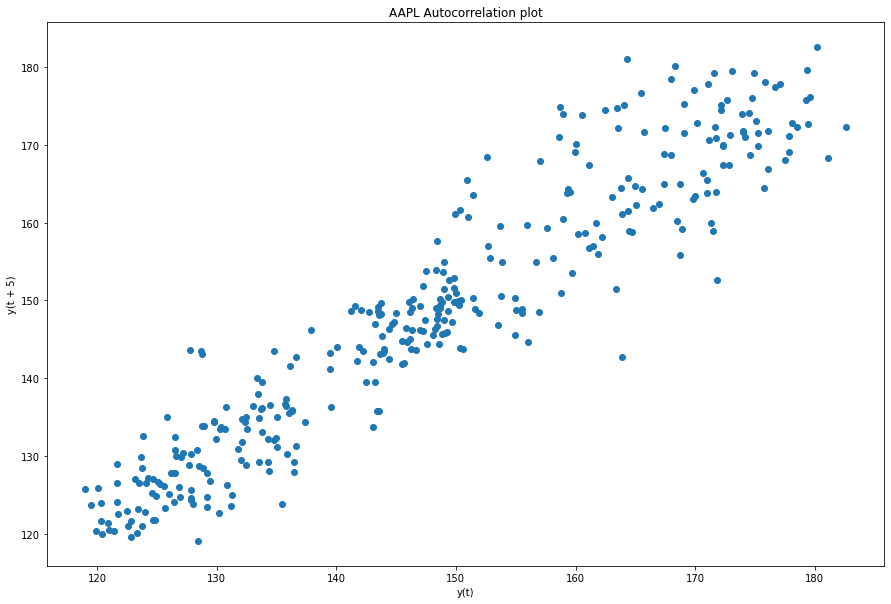

In [9]:
plt.figure(figsize=(15,10))
lag_plot(df['Open'],lag=5)
plt.title(symbol + " Autocorrelation plot")

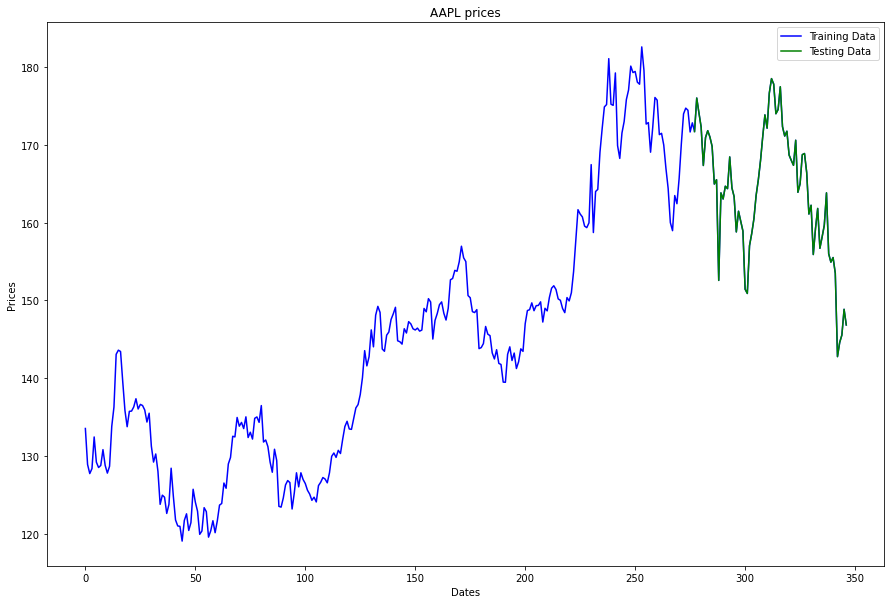

In [10]:
train_data, test_data = df[0:int(len(df)*0.8)],df[int(len(df)*0.8):]
plt.figure(figsize=(15,10))
plt.title(symbol + " prices")
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Open'],'blue', label='Training Data')
plt.plot(test_data['Open'],'green', label='Testing Data')

plt.legend()

In [11]:
def smape_kun(y_true,y_pred):
    return np.mean((np.abs(y_pred-y_true)*200/(np.abs(y_pred)+np.abs(y_true))))

C:\Users\ducan\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


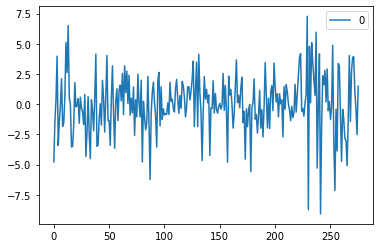

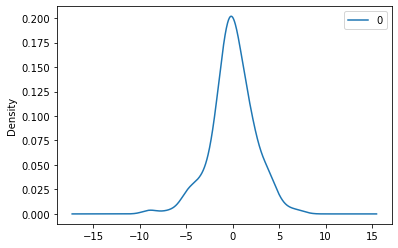

In [20]:
# check for resid plot and resid density plot to make sure it follows gaussian density

# modeling on training dataset
train_ar = np.nan_to_num(train_data['Open'].values)

model = sm.tsa.ARIMA(train_ar, order=(5,1,0))
model_fit = model.fit()

# residual plot
DataFrame(model_fit.resid).plot()
plt.show()

# residual density plot
DataFrame(model_fit.resid).plot(kind='kde')
plt.show()

In [13]:
# test dataset
test_ar = np.nan_to_num(test_data['Open'].values)

history = [x for x in train_ar]

predictions = list()
for t in range(len(test_ar)):
    model = sm.tsa.ARIMA(endog=history, order=(5,1,0))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)

error = mean_squared_error(test_ar, predictions)
print('Teting Mean Squared Error: %.3f' % error)

error2 = smape_kun(test_ar, predictions)
print("Symmetric mean absolute percentage error: %.3f" % error2)




C:\Users\ducan\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Teting Mean Squared Error: 15.479
Symmetric mean absolute percentage error: 5.741


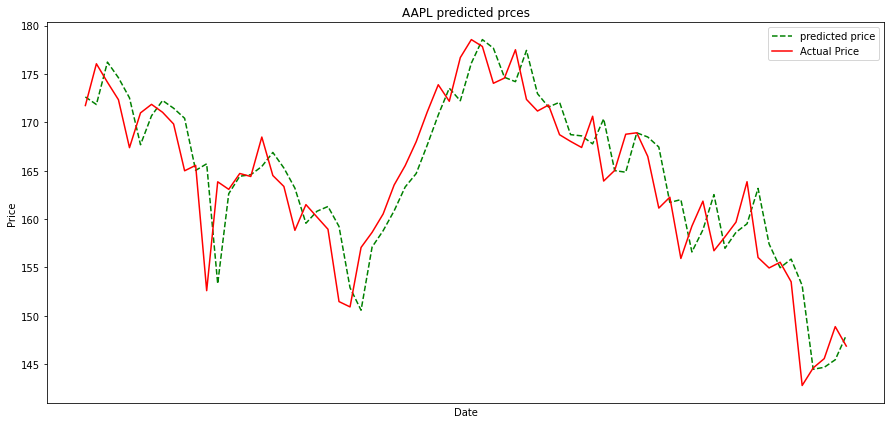

In [14]:
plt.figure(figsize = (15,7))
plt.plot(test_data.index,predictions, color="green", linestyle='dashed',label='predicted price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.xticks(np.arange(1486,100,90),df['Date'][1486:100:90])
plt.title(symbol + ' predicted prces')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [ ]:
# backtest : apply money. 

In [19]:
df1 = pd.DataFrame(test_ar[:10])
df1.rename(columns = {0:'Observations'}, inplace=True)

df2 = pd.DataFrame(predictions[:10])
df2.rename(columns = {0:'Predictions'}, inplace=True)

results = pd.concat([df1,df2],axis=1)

print(results)

   Observations  Predictions
0    171.729996   172.618557
1    176.050003   171.833320
2    174.139999   176.220542
3    172.330002   174.603115
4    167.369995   172.524504
5    170.970001   167.674891
6    171.850006   170.670869
7    171.029999   172.249736
8    169.820007   171.451666
9    164.979996   170.408723
